In [1]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from matplotlib.ticker import PercentFormatter
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy.stats import zscore
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from warnings import filterwarnings
import dataframe_image as dfi
import itertools
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor

In [2]:
file = pd.read_excel("Sales.xlsx","Sales")
#dfi is used to save the dataframe as image for business report
dfi.export(file.head(), 'MAIN file head.png')
# display first five observations using head()
file['Age']=file['Age1']
file=file.drop(["Age1"], axis=1)
file.head()

,CustID,AgentBonus,Age,CustTenure,Channel,Occupation,EducationField,Gender,ExistingProdType,Designation,NumberOfPolicy,MaritalStatus,MonthlyIncome,Complaint,ExistingPolicyTenure,SumAssured,Zone,PaymentMethod,LastMonthCalls,CustCareScore
0,7000000,4409,22.0,4.0,Agent,Salaried,Graduate,Female,3,Manager,2.0,Single,20993.0,1,2.0,806761.0,North,Half Yearly,5,2.0
1,7000001,2214,23.0,2.0,Third Party Partner,Salaried,Graduate,Male,4,Manager,4.0,Divorced,20130.0,0,3.0,294502.0,North,Yearly,7,3.0
2,7000002,4273,26.0,4.0,Agent,Free Lancer,Post Graduate,Male,4,Exe,3.0,Unmarried,17090.0,1,2.0,NaN,North,Yearly,0,3.0
3,7000003,1791,23.0,NaN,Third Party Partner,Salaried,Graduate,Fe male,3,Executive,3.0,Divorced,17909.0,1,2.0,268635.0,West,Half Yearly,0,5.0
4,7000004,2955,22.0,NaN,Agent,Small Business,UG,Male,3,Executive,4.0,Divorced,18468.0,0,4.0,366405.0,West,Half Yearly,2,5.0


In [3]:
pd.DataFrame(file.dtypes).loc["Age", 0] == 'float64'

True

In [4]:
df_datatypes = pd.DataFrame(file.dtypes)
df_null_count = file.count()
df_datatypes.columns = ['Type']
df_datatypes["Count"] = df_null_count
df_datatypes = df_datatypes[['Count', 'Type']]
dfi.export(df_datatypes, 'MAIN file info.png')
df_datatypes

,Count,Type
CustID,4520,int64
AgentBonus,4520,int64
Age,4251,float64
CustTenure,4294,float64
Channel,4520,object
Occupation,4520,object
EducationField,4520,object
Gender,4520,object
ExistingProdType,4520,int64
Designation,4520,object


In [5]:
data = file.copy()
data.drop(['CustID'], axis=1, inplace=True)
data.shape

(4520, 19)

In [6]:
for feature in data.select_dtypes(include=['object']).columns.values.tolist():
    print('\n')
    print('feature:', feature)
    print(data[feature].unique())



feature: Channel
['Agent' 'Third Party Partner' 'Online']


feature: Occupation
['Salaried' 'Free Lancer' 'Small Business' 'Laarge Business'
 'Large Business']


feature: EducationField
['Graduate' 'Post Graduate' 'UG' 'Under Graduate' 'Engineer' 'Diploma'
 'MBA']


feature: Gender
['Female' 'Male' 'Fe male']


feature: Designation
['Manager' 'Exe' 'Executive' 'VP' 'AVP' 'Senior Manager']


feature: MaritalStatus
['Single' 'Divorced' 'Unmarried' 'Married']


feature: Zone
['North' 'West' 'East' 'South']


feature: PaymentMethod
['Half Yearly' 'Yearly' 'Quarterly' 'Monthly']


In [7]:
data = data.replace('UG', 'Under Graduate')
data = data.replace('Fe male', 'Female')
data = data.replace('Exe', 'Executive')
data = data.replace('Laarge Business', 'Large Business')

In [8]:
for feature in data.select_dtypes(include=['object']).columns.values.tolist():
    print('\n')
    print('feature:', feature)
    print(data[feature].unique())



feature: Channel
['Agent' 'Third Party Partner' 'Online']


feature: Occupation
['Salaried' 'Free Lancer' 'Small Business' 'Large Business']


feature: EducationField
['Graduate' 'Post Graduate' 'Under Graduate' 'Engineer' 'Diploma' 'MBA']


feature: Gender
['Female' 'Male']


feature: Designation
['Manager' 'Executive' 'VP' 'AVP' 'Senior Manager']


feature: MaritalStatus
['Single' 'Divorced' 'Unmarried' 'Married']


feature: Zone
['North' 'West' 'East' 'South']


feature: PaymentMethod
['Half Yearly' 'Yearly' 'Quarterly' 'Monthly']


In [9]:
print("Pre null removal\n")
data_null = data.isna().sum()*100/data.shape[0]
data_null = data_null.to_frame()
data_null.columns = ['null percentage']
dfi.export(data_null, 'MAIN file pre null count.png')
data_null

Pre null removal



,null percentage
AgentBonus,0.000000
Age,5.951327
CustTenure,5.000000
Channel,0.000000
Occupation,0.000000
EducationField,0.000000
Gender,0.000000
ExistingProdType,0.000000
Designation,0.000000
NumberOfPolicy,0.995575


In [10]:
data=data.fillna(data.median())
print("post null removal\n")
data_null = data.isna().sum()*100/data.shape[0]
data_null = data_null.to_frame()
data_null.columns = ['null percentage']
dfi.export(data_null, 'MAIN file post null count.png')
data_null

C:\Users\naram\AppData\Local\Temp/ipykernel_25552/1757598315.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data=data.fillna(data.median())


post null removal



,null percentage
AgentBonus,0.0
Age,0.0
CustTenure,0.0
Channel,0.0
Occupation,0.0
EducationField,0.0
Gender,0.0
ExistingProdType,0.0
Designation,0.0
NumberOfPolicy,0.0


In [11]:
print(data.shape)
dups = data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

(4520, 19)
Number of duplicate rows = 0


In [12]:
dfi.export(data.describe(include="all").T, 'MAIN data describe.png')
data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
AgentBonus,4520.0,NaN,NaN,NaN,4077.838274,1403.321711,1605.0,3027.75,3911.5,4867.25,9608.0
Age,4520.0,NaN,NaN,NaN,23.644137,3.817241,18.0,22.0,23.0,24.0,58.0
CustTenure,4520.0,NaN,NaN,NaN,14.395575,8.742521,2.0,8.0,13.0,19.0,57.0
Channel,4520,3,Agent,3194,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,4520,4,Salaried,2192,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EducationField,4520,6,Graduate,1870,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,4520,2,Male,2688,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ExistingProdType,4520.0,NaN,NaN,NaN,3.688938,1.015769,1.0,3.0,4.0,4.0,6.0
Designation,4520,5,Executive,1662,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NumberOfPolicy,4520.0,NaN,NaN,NaN,3.56969,1.449302,1.0,2.0,4.0,5.0,6.0


In [13]:
data['Age_bin'] = pd.cut(data['Age'],
                         [0, 10, 20, 30,40, 50, 60],
                         labels=['0-10', '10-20', '20-30', '30-40', '40-50', '50-60'])

AgentBonus


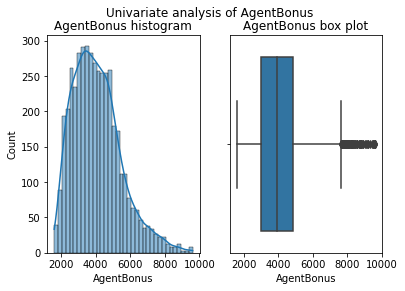

Age


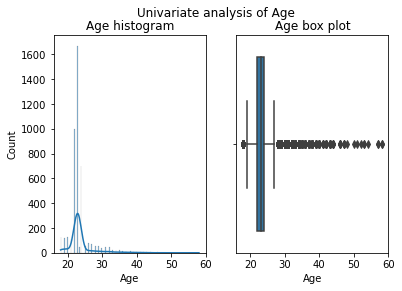

CustTenure


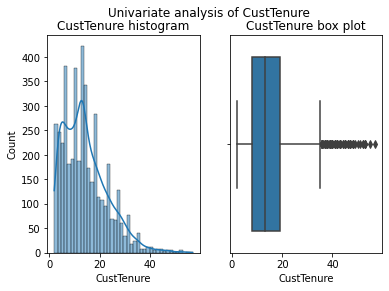

ExistingProdType


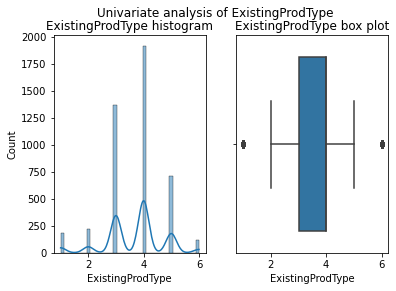

NumberOfPolicy


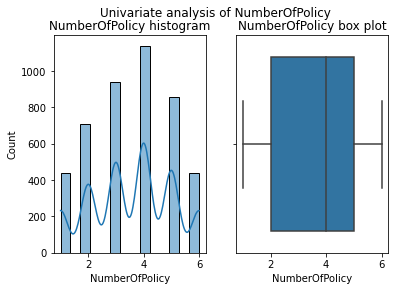

MonthlyIncome


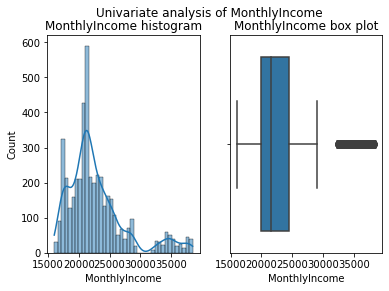

Complaint


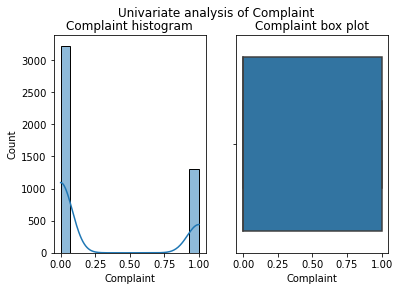

ExistingPolicyTenure


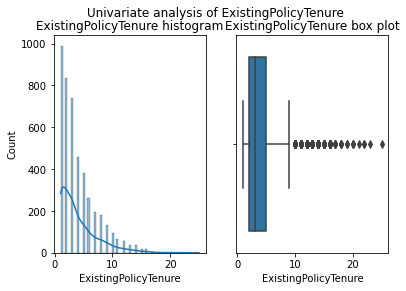

SumAssured


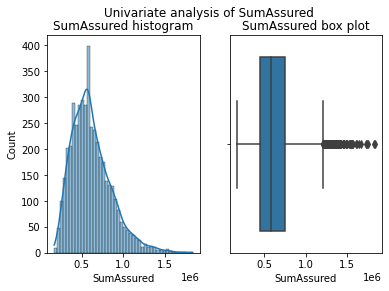

LastMonthCalls


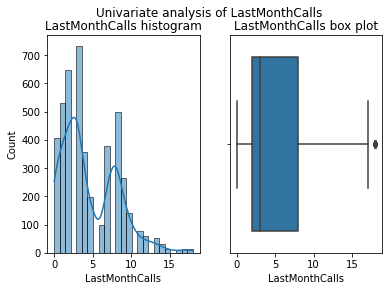

CustCareScore


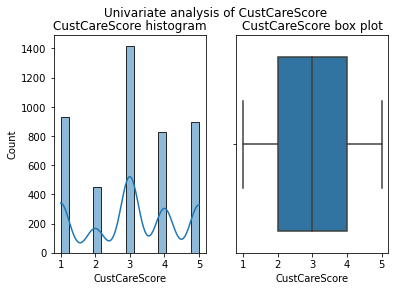

In [14]:
collist=data.select_dtypes(exclude=['object','category']).columns.values.tolist()
for column in collist:
    print(column)
    fig, ax = plt.subplots(1, 2)
    plt.suptitle('Univariate analysis of '+column)
    sns.histplot(data=data,x=column,ax=ax[0],kde=True)
    sns.boxplot(data=data,x=column,ax=ax[1])
    ax[0].set_title(column+" histogram")
    ax[1].set_title(column+" box plot")
    fig.savefig('MAIN data univariate of '+column+'.jpg', bbox_inches='tight', dpi=150)
    plt.show()

In [15]:
pd.DataFrame(data.dtypes)

,0
AgentBonus,int64
Age,float64
CustTenure,float64
Channel,object
Occupation,object
EducationField,object
Gender,object
ExistingProdType,int64
Designation,object
NumberOfPolicy,float64


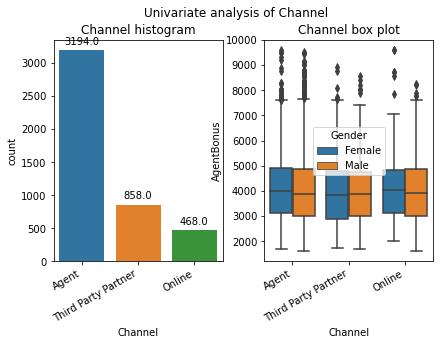

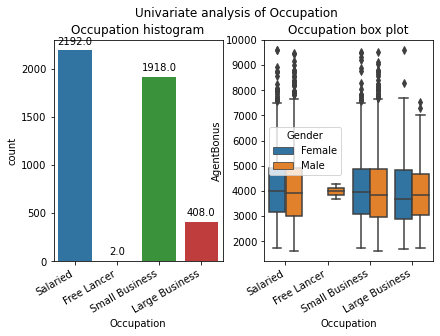

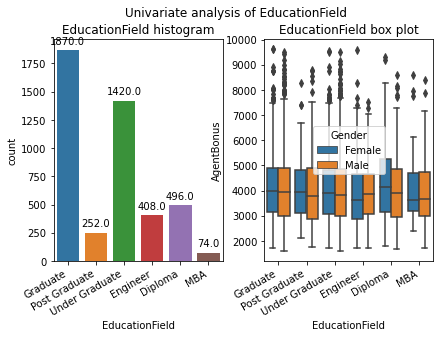

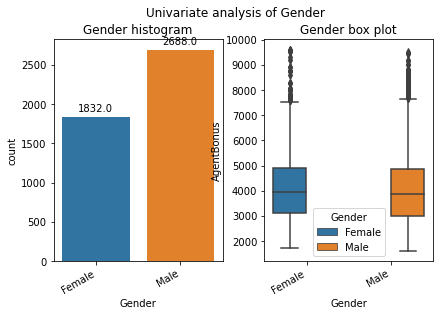

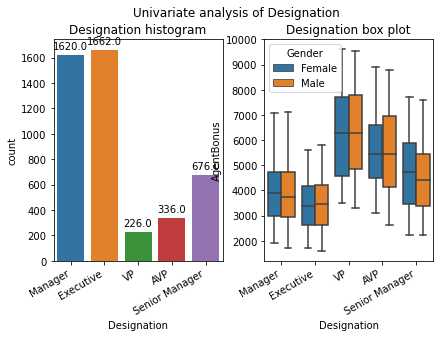

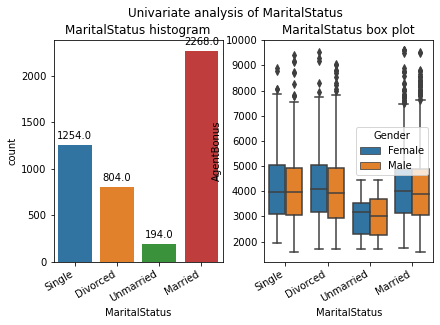

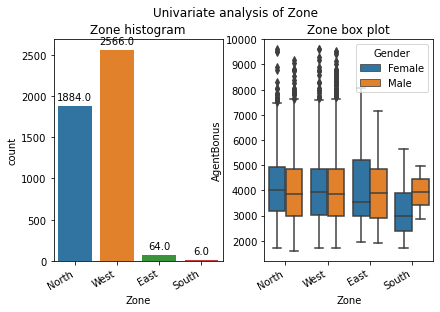

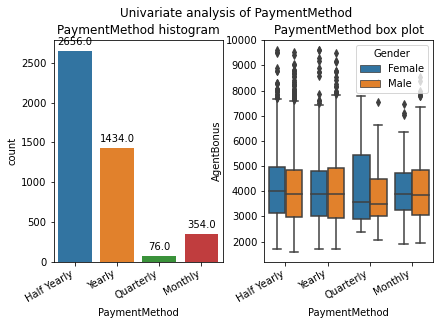

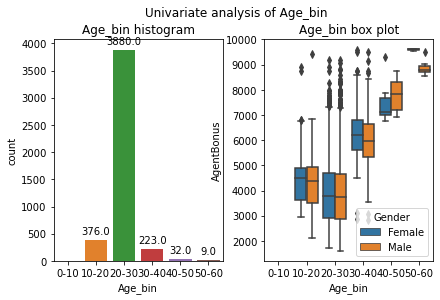

In [16]:
collist=data.select_dtypes(include=['object','category']).columns.values.tolist()
for column in collist:
    fig, ax = plt.subplots(1, 2)
    plt.suptitle('Univariate analysis of '+column)
    fig.tight_layout()
    dfi.export(data[column].value_counts().sort_values().to_frame(), 'MAIN data object '+column+' .png')
    splot = sns.countplot(data=data, x=column, ax=ax[0])
    sns.boxplot(data=data, x=column,
                ax=ax[1], y="AgentBonus", hue="Gender")
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.1f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')
    ax[0].set_title(column+" histogram")
    ax[1].set_title(column+" box plot")
    if pd.DataFrame(data.dtypes).loc[column, 0] == 'object':
        ax[0].set_xticklabels(data[column].unique(),rotation=30,ha= 'right')
        ax[1].set_xticklabels(data[column].unique(),rotation=30,ha= 'right')
    fig.savefig('MAIN data cat univariate of '+column+'.jpg', bbox_inches='tight', dpi=150)
    plt.show()

<Figure size 1440x1008 with 0 Axes>

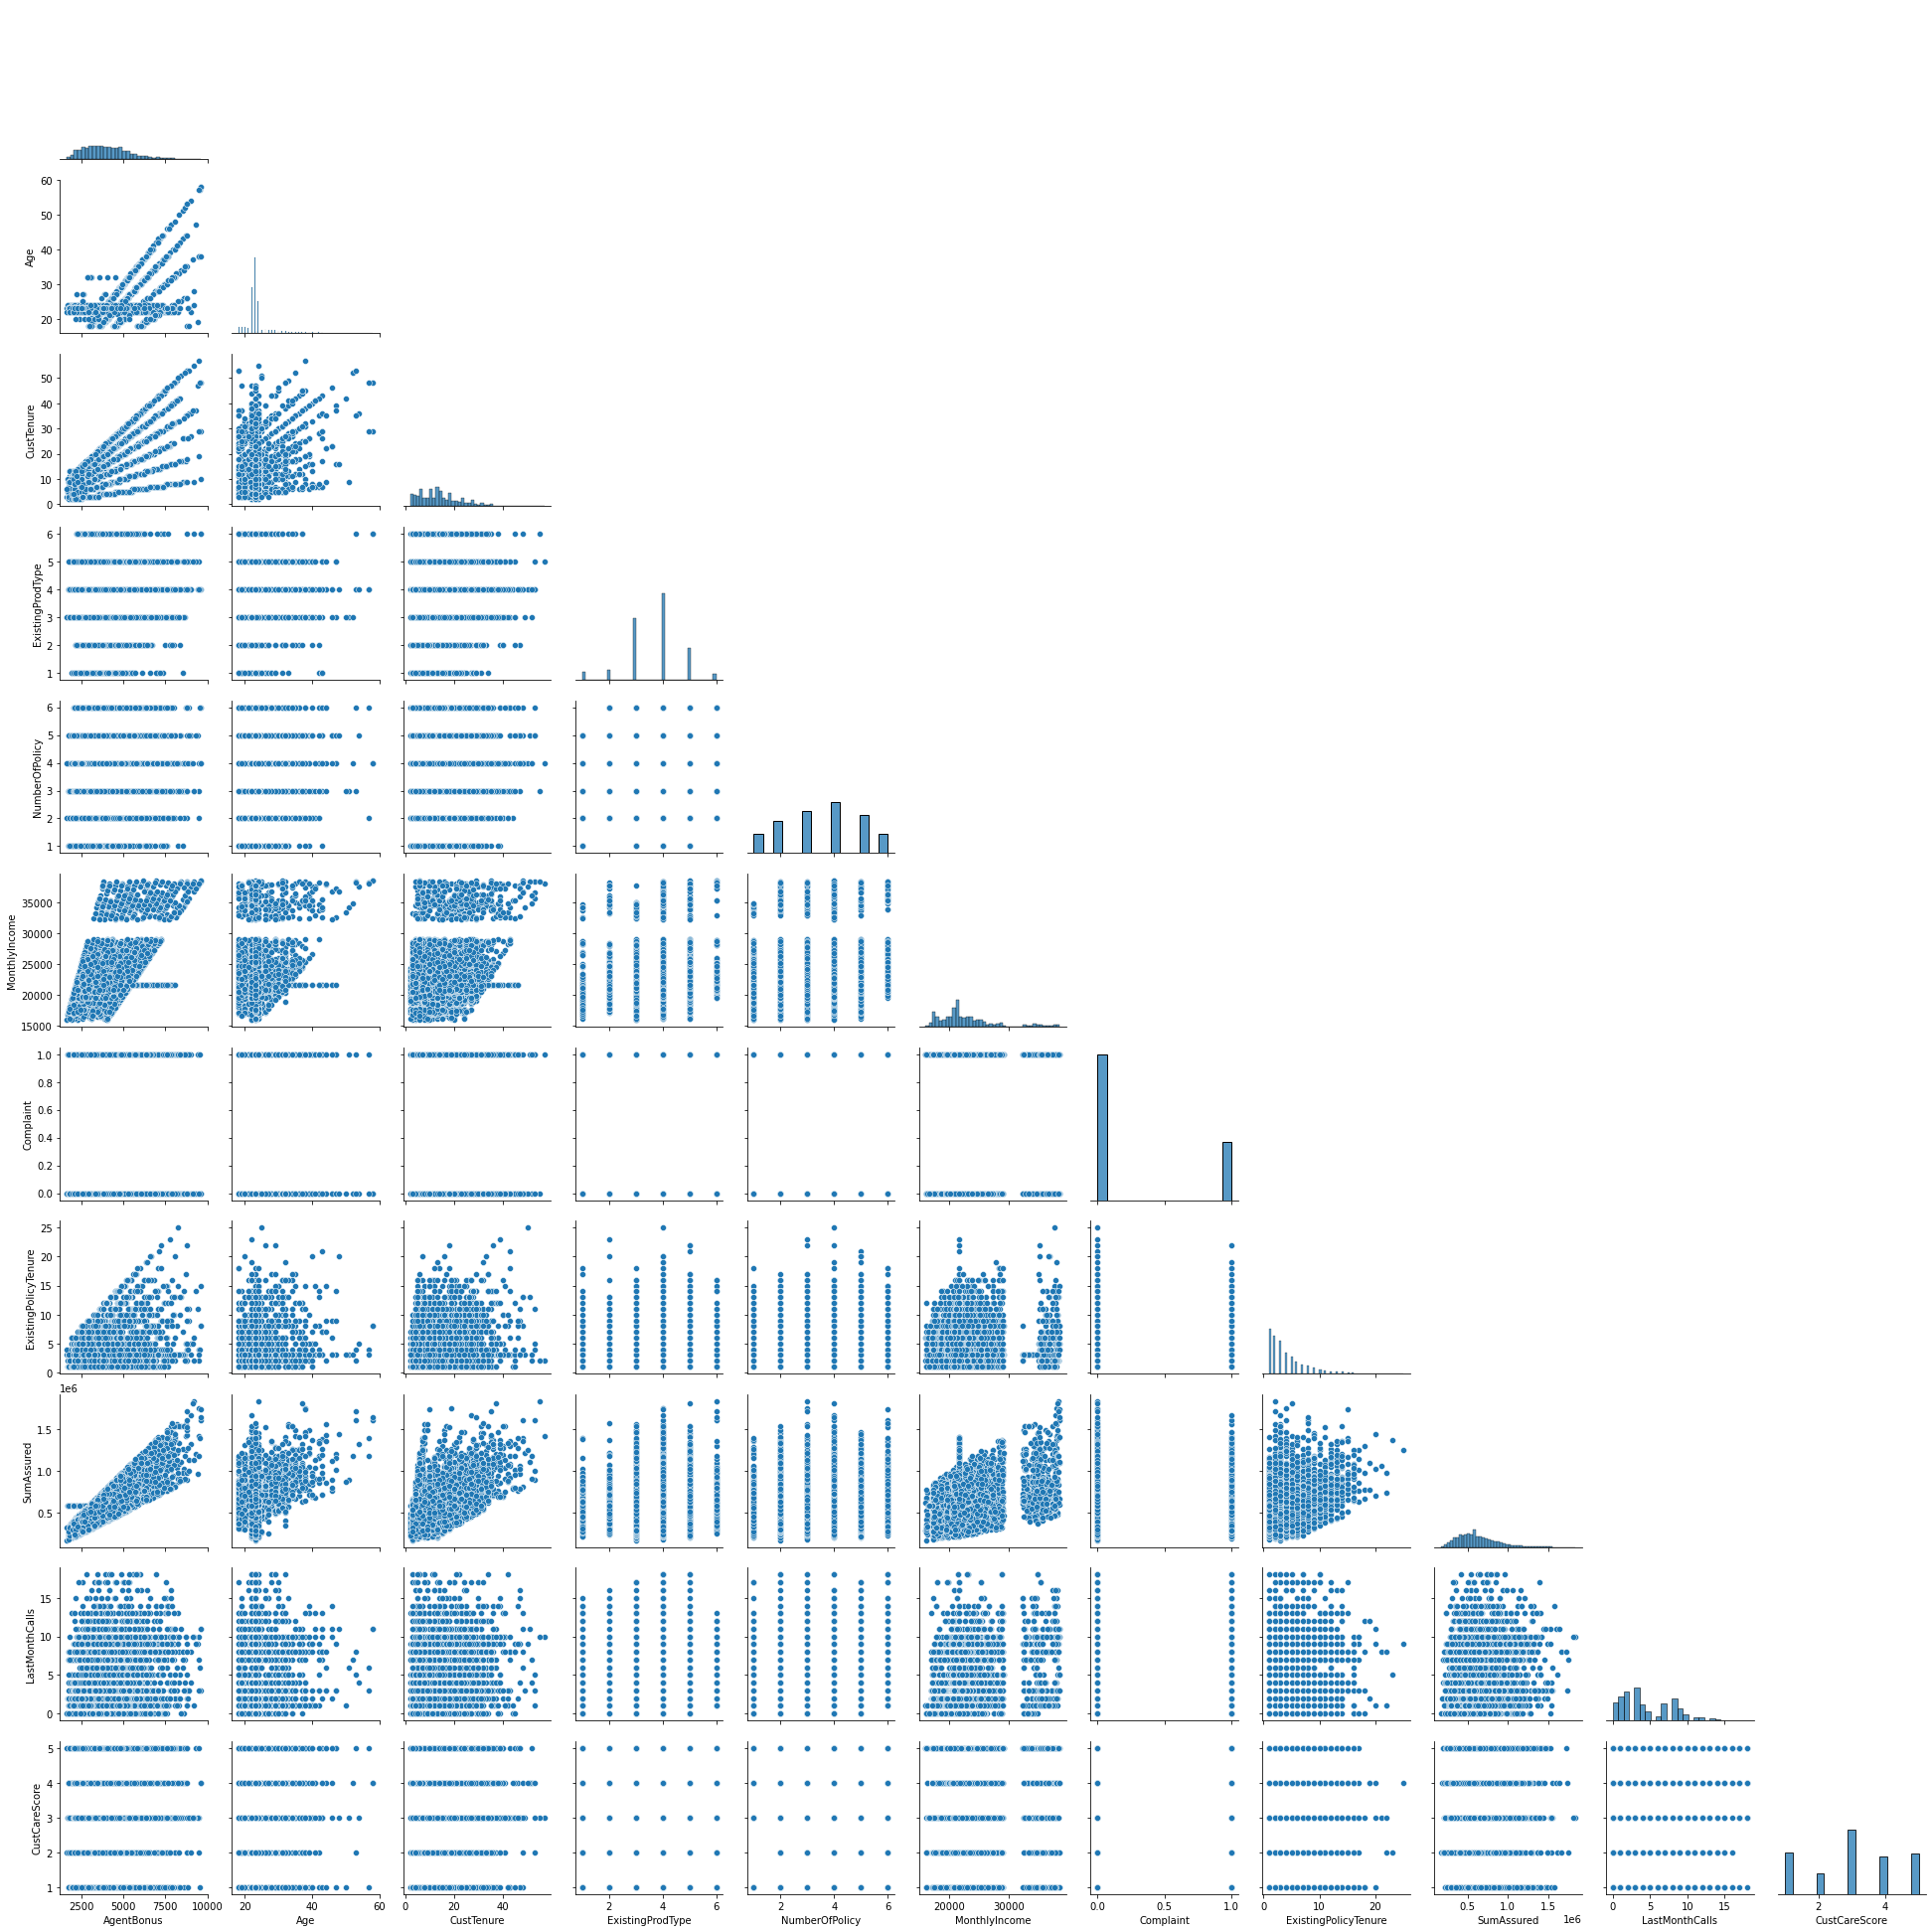

In [17]:
fig = plt.figure(figsize=(20, 14))
sns.pairplot(data.select_dtypes(exclude=['object']), corner=True)
fig.suptitle("Bivariate analysis", y=1.08)
fig.savefig('MAIN data pairplot.jpg')
plt.show()

C:\Users\naram\AppData\Local\Temp/ipykernel_25552/1070648225.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(data.select_dtypes(exclude=['object']).corr(), dtype=np.bool))


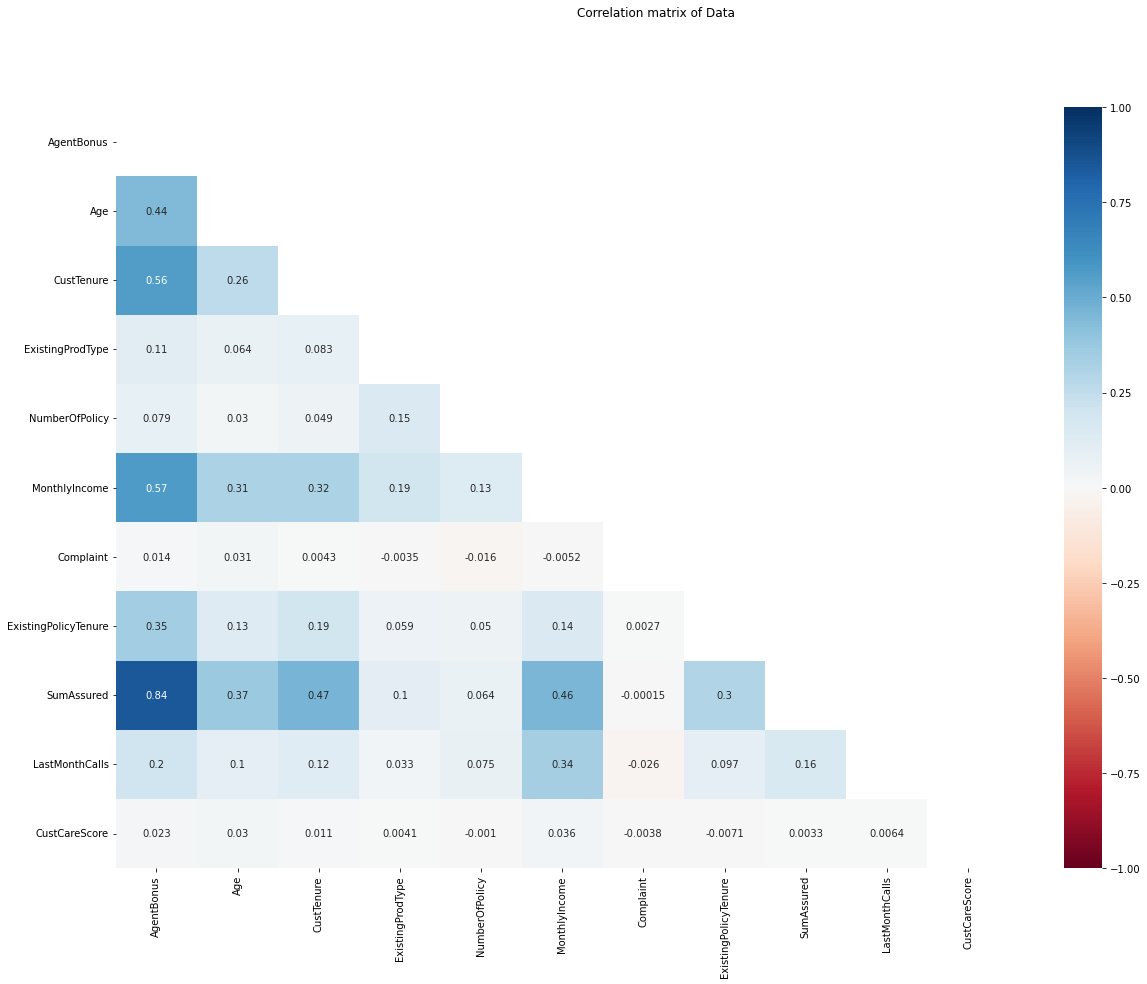

In [18]:
fig = plt.figure(figsize=(20, 14))
plt.suptitle('Correlation matrix of Data')
mask = np.triu(np.ones_like(data.select_dtypes(exclude=['object']).corr(), dtype=np.bool)) 
sns.heatmap(data.select_dtypes(exclude=['object']).corr(),cmap='RdBu',fmt='.2g',annot=True,mask=mask,vmin=-1,vmax=1)
fig.savefig('MAIN data heatmap.jpg', bbox_inches='tight', dpi=150)
plt.show()

Channel Occupation


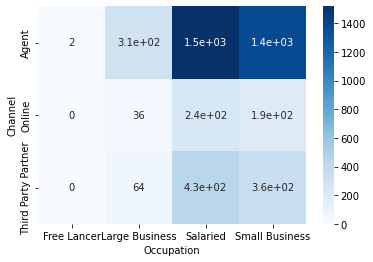

Channel EducationField


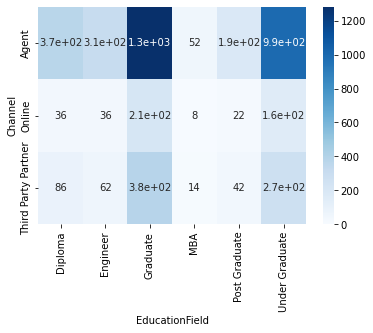

Channel Gender


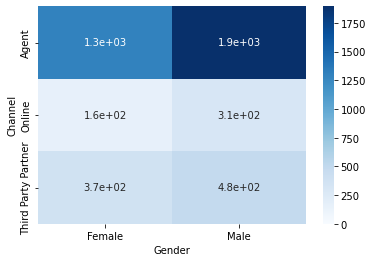

Channel Designation


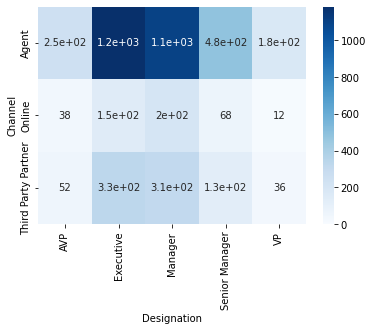

Channel MaritalStatus


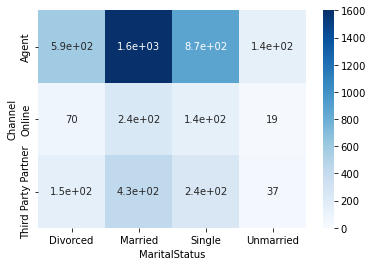

Channel Zone


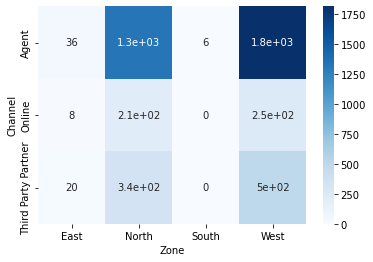

Channel PaymentMethod


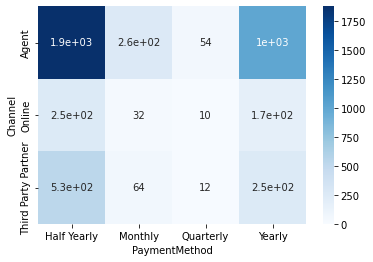

Occupation EducationField


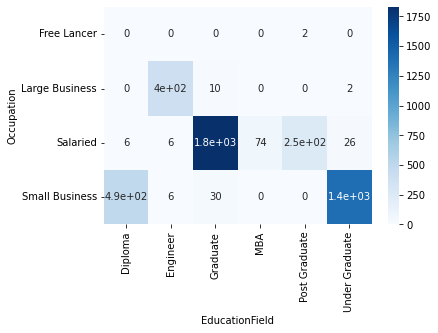

Occupation Gender


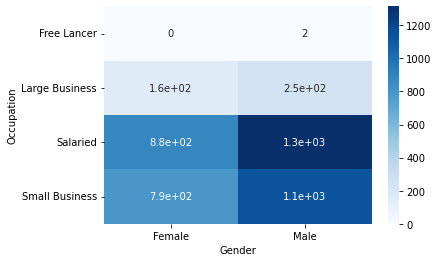

Occupation Designation


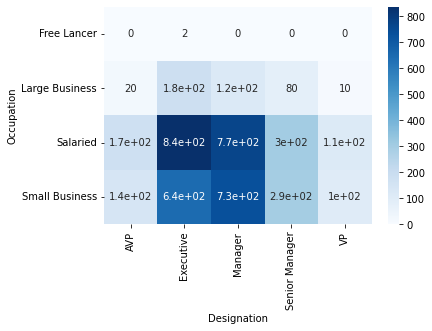

Occupation MaritalStatus


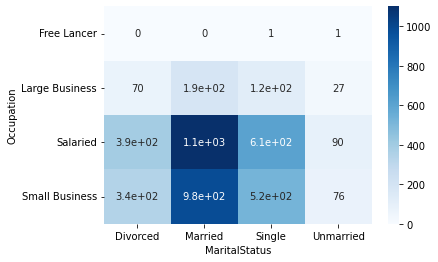

Occupation Zone


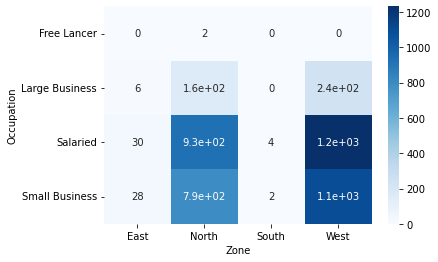

Occupation PaymentMethod


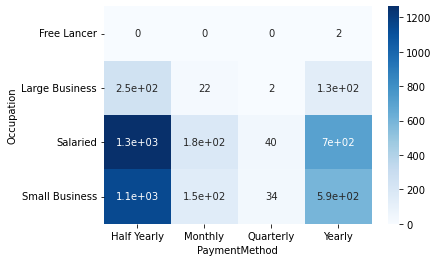

EducationField Gender


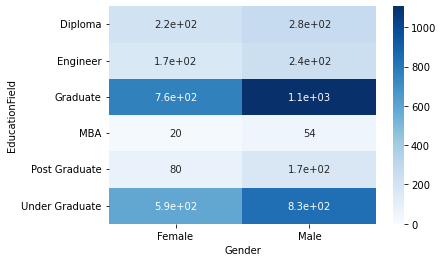

EducationField Designation


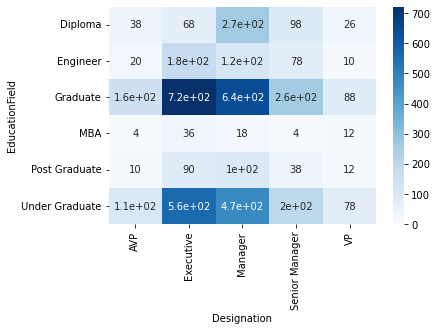

EducationField MaritalStatus


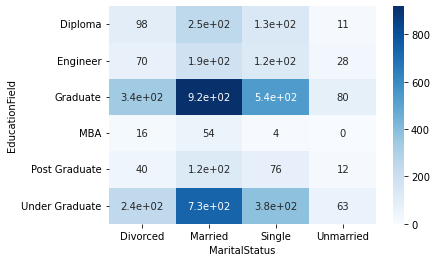

EducationField Zone


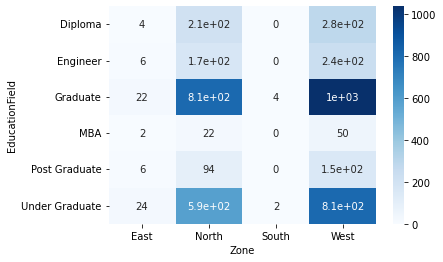

EducationField PaymentMethod


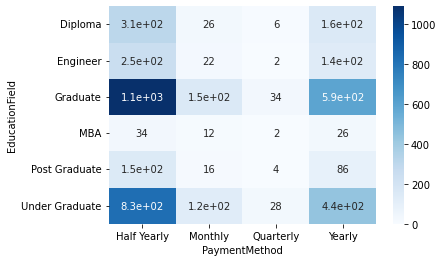

Gender Designation


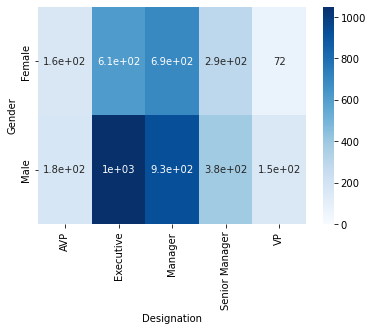

Gender MaritalStatus


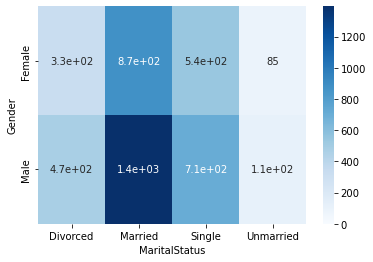

Gender Zone


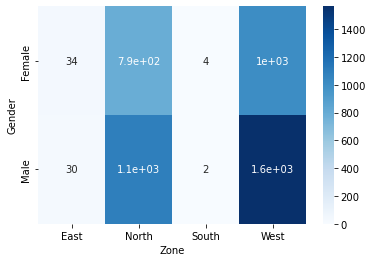

Gender PaymentMethod


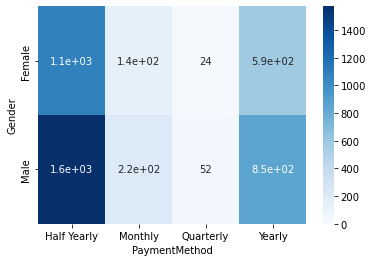

Designation MaritalStatus


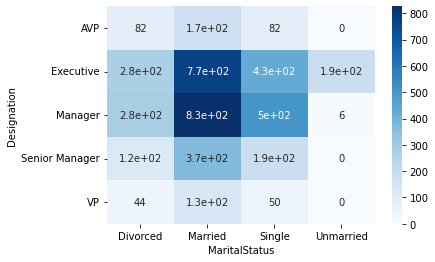

Designation Zone


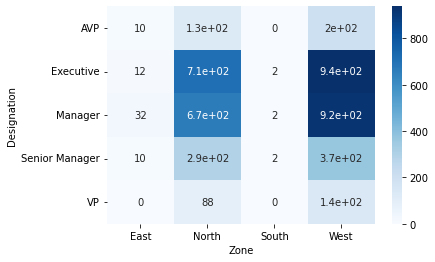

Designation PaymentMethod


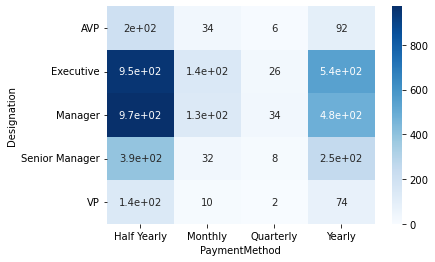

MaritalStatus Zone


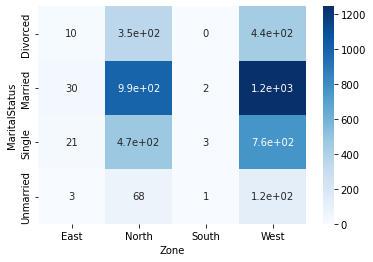

MaritalStatus PaymentMethod


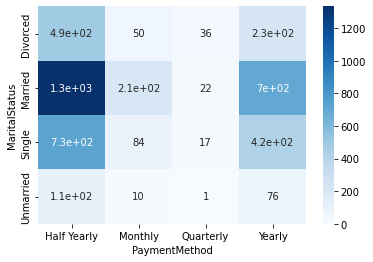

Zone PaymentMethod


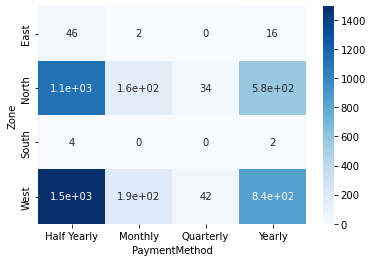

In [19]:
collist = data.select_dtypes(include=['object']).columns.values.tolist()
for i in range(len(collist)):
    for j in range(i+1,len(collist)):
        k=collist[i]
        j=collist[j]
        print(k,j)
        fig = plt.figure()
        sns.heatmap(pd.crosstab(data[k], data[j]), cmap='Blues',
                    fmt='.2g', annot=True, vmin=0)
        fig.savefig('MAIN data heatmap cross tab of'+k+' and '+j+'.jpg', bbox_inches='tight', dpi=150)
        plt.show()

In [20]:
for feature in data.select_dtypes(include=['object','category']).columns.values.tolist(): 
    print('\n')
    print('feature:',feature)
    print(pd.Categorical(data[feature].unique()))
    print(pd.Categorical(data[feature].unique()).codes)
    data[feature] = pd.Categorical(data[feature]).codes
for feature in ['ExistingProdType', 'CustCareScore', 'Complaint']:
    print('\n')
    print('feature:', feature)
    print(pd.Categorical(data[feature].unique()).codes)
    data[feature] = pd.Categorical(data[feature]).codes



feature: Channel
['Agent', 'Third Party Partner', 'Online']
Categories (3, object): ['Agent', 'Online', 'Third Party Partner']
[0 2 1]


feature: Occupation
['Salaried', 'Free Lancer', 'Small Business', 'Large Business']
Categories (4, object): ['Free Lancer', 'Large Business', 'Salaried', 'Small Business']
[2 0 3 1]


feature: EducationField
['Graduate', 'Post Graduate', 'Under Graduate', 'Engineer', 'Diploma', 'MBA']
Categories (6, object): ['Diploma', 'Engineer', 'Graduate', 'MBA', 'Post Graduate', 'Under Graduate']
[2 4 5 1 0 3]


feature: Gender
['Female', 'Male']
Categories (2, object): ['Female', 'Male']
[0 1]


feature: Designation
['Manager', 'Executive', 'VP', 'AVP', 'Senior Manager']
Categories (5, object): ['AVP', 'Executive', 'Manager', 'Senior Manager', 'VP']
[2 1 4 0 3]


feature: MaritalStatus
['Single', 'Divorced', 'Unmarried', 'Married']
Categories (4, object): ['Divorced', 'Married', 'Single', 'Unmarried']
[2 0 3 1]


feature: Zone
['North', 'West', 'East', 'South'

In [21]:
data = data.drop("Age", axis=1)
Y = data["AgentBonus"]
X = data.drop("AgentBonus", axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=1)

In [23]:
# feature selection
def select_features(X_train, y_train, X_test, k):
    fs = SelectKBest(score_func=mutual_info_regression, k=k)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    cols = fs.get_support(indices=True)
    return X_train_fs, X_test_fs, fs, cols

In [24]:
# feature selection
LR_metrics = pd.DataFrame()
for k in range(1, X_train.shape[1]):
    for i in list(itertools.combinations(X_train.columns, k)):
        X_train_i = X_train[list(i)]
        X_test_i = X_test[list(i)]
        model = LinearRegression()
        model.fit(X_train_i, y_train)
        # evaluate the model
        yhat = model.predict(X_test_i)
        # evaluate predictions
        mae = mean_absolute_error(y_test, yhat)
        mse = mean_squared_error(y_test, yhat)
        LR_metrics = LR_metrics.append(
            {'col': i, 'mae': mae, 'mse': mse}, ignore_index=True)
    print(k)
LR_metrics.sort_values(by=['mse']).reset_index(drop=True).reset_index(drop=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


,col,mae,mse
0,"(CustTenure, Occupation, EducationField, Desig...",511.988021,4.228065e+05
1,"(CustTenure, Occupation, EducationField, Desig...",511.973983,4.228081e+05
2,"(CustTenure, Occupation, EducationField, Desig...",511.945751,4.228250e+05
3,"(CustTenure, Occupation, EducationField, Desig...",511.929203,4.228267e+05
4,"(CustTenure, Occupation, EducationField, Desig...",512.193390,4.228491e+05
...,...,...,...
262137,"(Occupation, EducationField, Zone, PaymentMeth...",1110.134389,1.962508e+06
262138,"(EducationField, Complaint, Zone, PaymentMetho...",1112.216330,1.962594e+06
262139,"(EducationField, Zone, PaymentMethod, CustCare...",1111.880478,1.962893e+06
262140,"(Occupation, Complaint, Zone, PaymentMethod, C...",1111.143892,1.963125e+06


In [25]:
LR_metrics.sort_values(by=['mse']).reset_index(
    drop=True).reset_index(drop=True).loc[0, 'col']

('CustTenure',
 'Occupation',
 'EducationField',
 'Designation',
 'MonthlyIncome',
 'Complaint',
 'ExistingPolicyTenure',
 'SumAssured',
 'LastMonthCalls',
 'Age_bin')

In [26]:
LR_metrics.sort_values(by=['mse']).reset_index(
    drop=True).reset_index(drop=True).loc[0,['mse','mae']]

mse    422806.529263
mae       511.988021
Name: 0, dtype: object

In [27]:
chi_square_value, p_value = calculate_bartlett_sphericity(
    data.drop('AgentBonus', axis=1))
if p_value < .05:
    print("PCA is needed\nP value:-", p_value)
else:
    print("PCA is not needed\nP value:-", p_value)

PCA is needed
P value:- 0.0


In [28]:
kmo_all, kmo_model = calculate_kmo(data.drop('AgentBonus', axis=1))
if kmo_model > .5:
    print("PCA is needed\nKMO value:-", kmo_model)
else:
    print("PCA is not needed\nKMO value:-", kmo_model)

PCA is needed
KMO value:- 0.633064835993167


In [29]:
data_scaled = data.drop('AgentBonus', axis=1).apply(zscore)
cov_matrix = np.cov(data_scaled.T)
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)
print("\nncomp",np.where(np.cumsum([( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)])>75.0)[0][0]+1)
from statsmodels.multivariate.pca import PCA
pc = PCA(data.drop('AgentBonus', axis=1), ncomp=np.where(np.cumsum(
    [(i / tot) * 100 for i in sorted(eig_vals, reverse=True)]) > 75.0)[0][0]+1)
data1_comp = pc.loadings.T

Cumulative Variance Explained [ 13.73006456  22.1146701   30.3669384   36.86121204  43.0009053
  48.84237969  54.64819157  60.18011357  65.56073878  70.6602277
  75.72227841  80.6477622   85.13370117  89.29570674  92.36376005
  95.21676641  97.83713286 100.        ]

ncomp 11


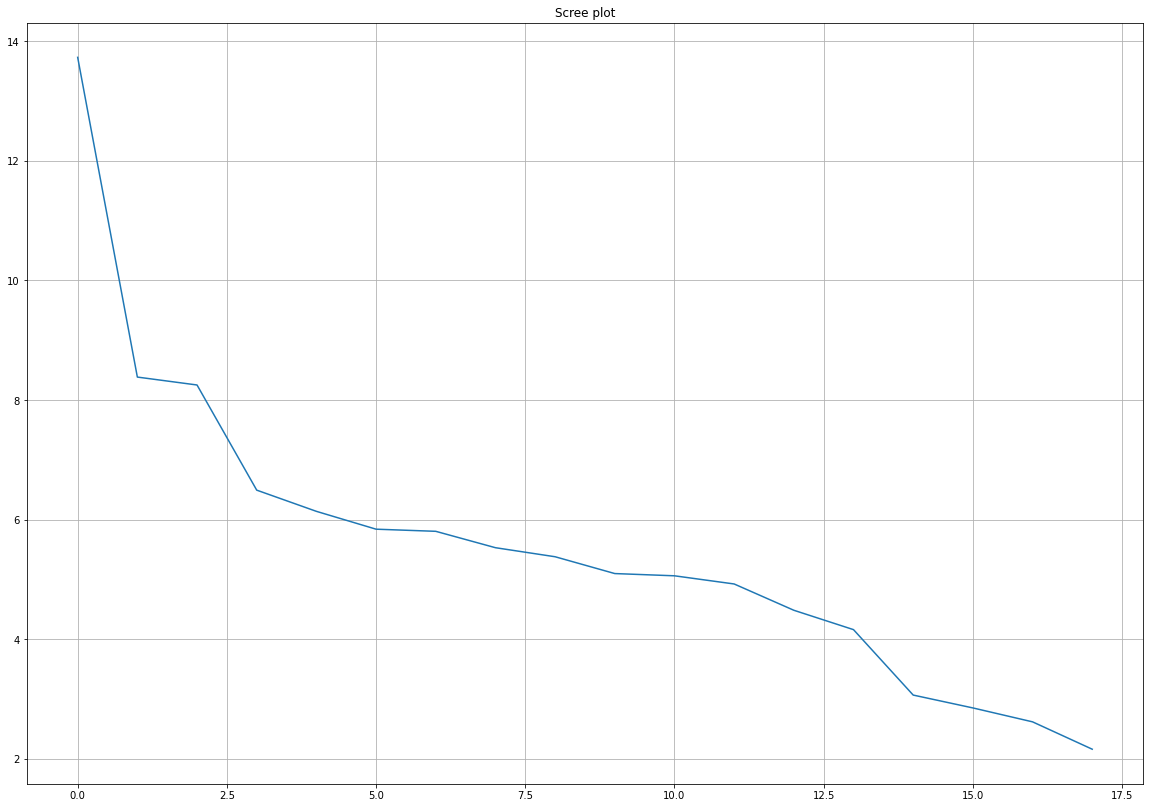

In [30]:
fig = plt.figure(figsize=(20, 14))
plt.plot(var_exp)
plt.title('Scree plot')
plt.grid()
fig.savefig('PCA Scree plot.jpg', bbox_inches='tight', dpi=150)
plt.show()

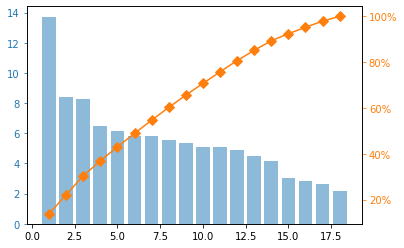

In [31]:
fig, ax = plt.subplots()
ax.bar(range(1, eig_vals.size + 1), var_exp, alpha=0.5, align='center',
       label='Individual explained variance', color="C0")
ax2 = ax.twinx()
ax2.plot(range(1, eig_vals.size + 1), cum_var_exp,
         label='Cumulative explained variance', color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
fig.savefig('PCA Pereto plot.jpg', bbox_inches='tight', dpi=150)
plt.show()

In [32]:
data1_comp.abs().T

,comp_00,comp_01,comp_02,comp_03,comp_04,comp_05,comp_06,comp_07,comp_08,comp_09,comp_10
CustTenure,0.385615,0.063324,0.039506,0.351698,0.043256,0.077379,0.068125,0.097779,0.042336,0.002216,0.050136
Channel,0.044187,0.012638,0.023939,0.074276,0.035587,0.007768,0.689913,0.372656,0.422813,0.284178,0.295971
Occupation,0.022130,0.516420,0.473818,0.016125,0.010398,0.012062,0.024699,0.000357,0.027126,0.030832,0.045290
EducationField,0.037442,0.499280,0.488574,0.045393,0.050670,0.051753,0.032349,0.014851,0.016113,0.049606,0.026480
Gender,0.032967,0.006354,0.006901,0.180890,0.456528,0.334983,0.381465,0.014008,0.423067,0.331615,0.057749
ExistingProdType,0.176061,0.471245,0.478638,0.005454,0.004964,0.060925,0.024805,0.003050,0.037381,0.032218,0.009476
Designation,0.330077,0.043667,0.038408,0.445845,0.131334,0.308222,0.014369,0.022860,0.070770,0.085708,0.061725
NumberOfPolicy,0.132499,0.082130,0.143281,0.114417,0.453075,0.346488,0.044825,0.147034,0.380908,0.353211,0.406365
MaritalStatus,0.125855,0.095841,0.054485,0.238228,0.212288,0.475660,0.068420,0.315191,0.265939,0.141020,0.249178
MonthlyIncome,0.497924,0.035545,0.005361,0.220512,0.084666,0.033178,0.036521,0.067715,0.024632,0.045252,0.015228


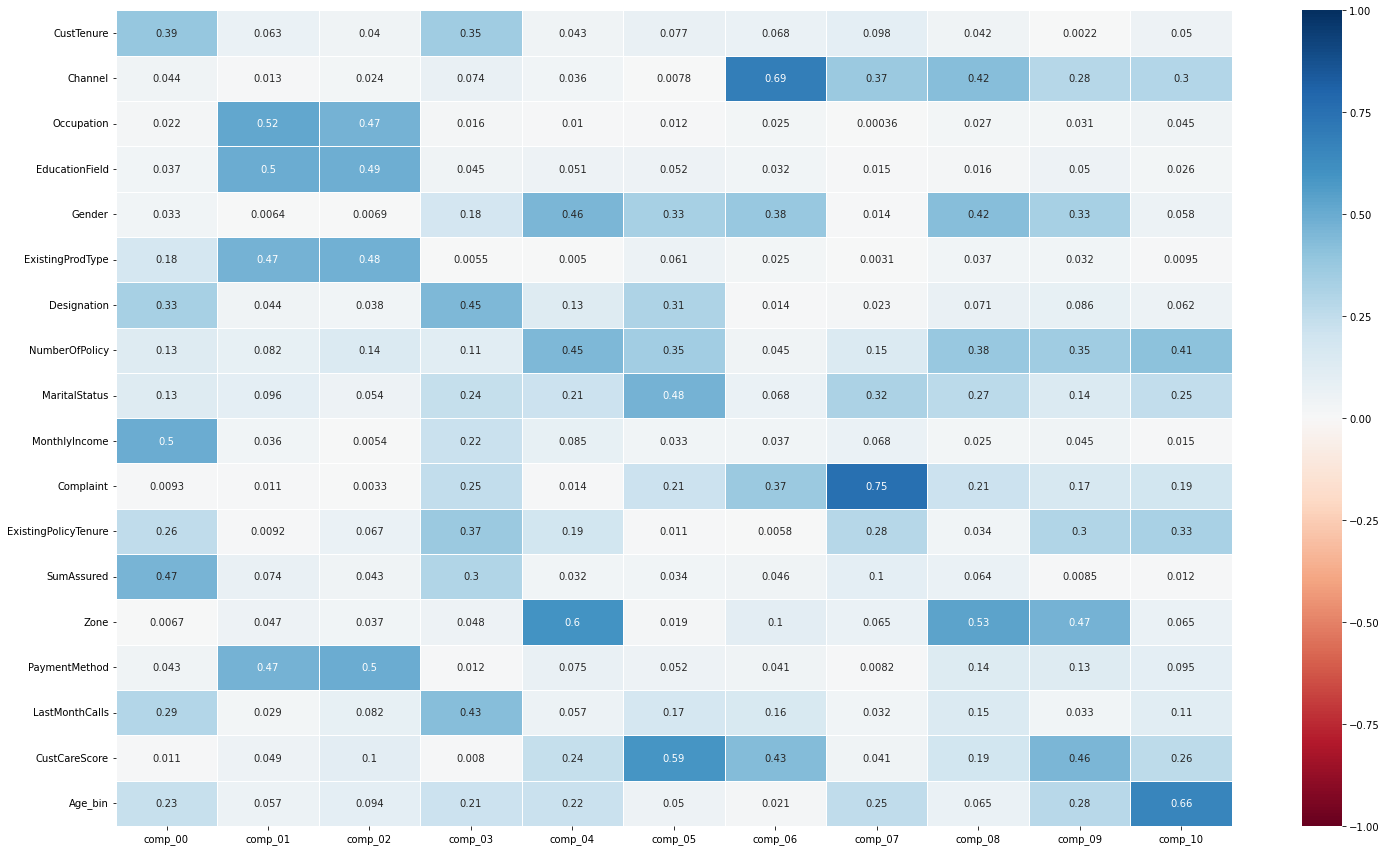

In [33]:
fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(data1_comp.abs().T, annot=True, linewidths=.5,
            ax=ax, cmap='RdBu', vmin=-1, vmax=1)
fig.savefig('PCA comp heat map.jpg', bbox_inches='tight', dpi=150)
plt.show()

In [34]:
maxValueIndexObj = data1_comp.abs().T.idxmax(axis=1)
dfi.export(maxValueIndexObj.to_frame(), 'PCA Comp mapping.png')
print("Max values of row are at following columns :")
print(maxValueIndexObj)

Max values of row are at following columns :
CustTenure              comp_00
Channel                 comp_06
Occupation              comp_01
EducationField          comp_01
Gender                  comp_04
ExistingProdType        comp_02
Designation             comp_03
NumberOfPolicy          comp_04
MaritalStatus           comp_05
MonthlyIncome           comp_00
Complaint               comp_07
ExistingPolicyTenure    comp_03
SumAssured              comp_00
Zone                    comp_04
PaymentMethod           comp_02
LastMonthCalls          comp_03
CustCareScore           comp_05
Age_bin                 comp_10
dtype: object


In [35]:
sorted([[v, k] for k, v in maxValueIndexObj.to_dict().items()], key=lambda x: x[0])

[['comp_00', 'CustTenure'],
 ['comp_00', 'MonthlyIncome'],
 ['comp_00', 'SumAssured'],
 ['comp_01', 'Occupation'],
 ['comp_01', 'EducationField'],
 ['comp_02', 'ExistingProdType'],
 ['comp_02', 'PaymentMethod'],
 ['comp_03', 'Designation'],
 ['comp_03', 'ExistingPolicyTenure'],
 ['comp_03', 'LastMonthCalls'],
 ['comp_04', 'Gender'],
 ['comp_04', 'NumberOfPolicy'],
 ['comp_04', 'Zone'],
 ['comp_05', 'MaritalStatus'],
 ['comp_05', 'CustCareScore'],
 ['comp_06', 'Channel'],
 ['comp_07', 'Complaint'],
 ['comp_10', 'Age_bin']]

In [36]:
type(maxValueIndexObj)

pandas.core.series.Series

In [37]:
X_2 = sm.add_constant(pc.factors)
model1 = sm.OLS(Y, X_2).fit()
model1.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             AgentBonus   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     982.9
Date:                Thu, 17 Feb 2022   Prob (F-statistic):               0.00
Time:                        23:42:43   Log-Likelihood:                -36403.
No. Observations:                4520   AIC:                         7.283e+04
Df Residuals:                    4508   BIC:                         7.291e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4077.8383     11.336    359.711      0.000    4055.613    4100.063
comp_00     7.322e+04    762.160     96.064      0.000    7.17e+04    7.47e+04
comp_01    -8041.7282    762.160    -10.551      0.000   -9535.935   -6547.521
comp_02     5495.6798    762.160      7.211      0.000    4001.473    6989.887
comp_03    -2.689e+04    762.160    -35.275      0.000   -2.84e+04   -2.54e+04
comp_04     4054.8659    762.160      5.320      0.000    2560.659    5549.073
comp_05    -3729.6036    762.160     -4.893      0.000   -5223.811   -2235.397
comp_06    -2088.8335    762.160     -2.741      0.006   -3583.040    -594.627
comp_07     6783.0856    762.160      8.900      0.000    5288.879    8277.293
comp_08    -4433.8500    762.160     -5.817      0.000   -5928.057   -2939.643
comp_09      819.4116    762.160      1.075      0.282    -674.795    2313.619
comp_10    -1153.6625    762.160     -1.514      0.130   -2647.869     340.544
==============================================================================
Omnibus:                      241.550   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              285.103
Skew:                           0.571   Prob(JB):                     1.23e-62
Kurtosis:                       3.460   Cond. No.                         67.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
print('The variation in the dependent variable which is explained by the independent variable is ',
      model1.rsquared*100, '%')

The variation in the dependent variable which is explained by the independent variable is  70.57481811318766 %


In [39]:
X_train_i = pc.factors
y_train_i=Y
model = LinearRegression()
model.fit(X_train_i, y_train_i)
# evaluate the model
yhat = model.predict(X_train_i)
# evaluate predictions
mae = mean_absolute_error(y_train_i, yhat)
mse = mean_squared_error(y_train_i, yhat)
print('mse',mse,'\nmae',mae)

mse 579345.3838874538 
mae 605.4617366173047


In [40]:
collist = list(LR_metrics.sort_values(by=['mse']).reset_index(
    drop=True).reset_index(drop=True).loc[0, 'col'])
collist

['CustTenure',
 'Occupation',
 'EducationField',
 'Designation',
 'MonthlyIncome',
 'Complaint',
 'ExistingPolicyTenure',
 'SumAssured',
 'LastMonthCalls',
 'Age_bin']

In [41]:
X_train_i = X_train[collist]
X_test_i = X_test[collist]
model_n_b = GaussianNB()
model_n_b.fit(X_train_i, y_train)
# evaluate the model
yhat = model_n_b.predict(X_test_i)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
print('mse',mse,'\nmae',mae)

mse 759621.9292035399 
mae 653.622418879056


In [42]:
model_SVR = SVR(kernel='rbf')
model_SVR.fit(X_train_i, y_train)
# evaluate the model
yhat = model_SVR.predict(X_test_i)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
print('mse',mse,'\nmae',mae)

mse 1401289.7876900986 
mae 907.1755789458981


In [43]:

X_train_i = X_train[list(i)]
X_test_i = X_test[list(i)]
model_RF = RandomForestRegressor(max_depth=2, random_state=0)
model_RF.fit(X_train_i, y_train)
# evaluate the model
yhat = model_RF.predict(X_test_i)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
print('mse', mse, '\nmae', mae)


mse 668379.9938745537 
mae 640.2521429333992


In [44]:

regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X_train_i, y_train)
yhat = model_RF.predict(X_test_i)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
print('mse', mse, '\nmae', mae)


mse 668379.9938745537 
mae 640.2521429333992


In [45]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [46]:

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=100, cv=3, verbose=1, random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train_i, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=1)

In [47]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [59]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy
base_model = RandomForestRegressor(n_estimators=10, random_state=42)
base_model.fit(X_train_i, y_train)
random_accuracy = evaluate(base_model, X_test_i, y_test)
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_i, y_test)
print('Improvement of {:0.2f}%.'.format(
    100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 455.3397 degrees.
Accuracy = 87.99%.


ValueError: X has 10 features, but DecisionTreeRegressor is expecting 17 features as input.

In [61]:
best_random


RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=1600)

In [49]:
NB_metrics = pd.DataFrame()
for k in range(1, X_train.shape[1]):
    for i in list(itertools.combinations(X_train.columns, k)):
        X_train_i = X_train[list(i)]
        X_test_i = X_test[list(i)]
        model_n_b = GaussianNB()
        model_n_b.fit(X_train_i, y_train)
        # evaluate the model
        yhat = model_n_b.predict(X_test_i)
        # evaluate predictions
        mae = mean_absolute_error(y_test, yhat)
        mse = mean_squared_error(y_test, yhat)
        NB_metrics = NB_metrics.append(
            {'col': i, 'mae': mae, 'mse': mse}, ignore_index=True)
    print(k)
NB_metrics.sort_values(by=['mse']).reset_index(drop=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


,col,mae,mse
0,"(CustTenure, Occupation, EducationField, Exist...",642.811209,7.423492e+05
1,"(CustTenure, EducationField, Gender, ExistingP...",643.085546,7.424394e+05
2,"(CustTenure, EducationField, ExistingProdType,...",643.244838,7.427085e+05
3,"(CustTenure, Channel, EducationField, Gender, ...",643.644543,7.427600e+05
4,"(CustTenure, EducationField, Gender, ExistingP...",643.829646,7.427868e+05
...,...,...,...
262137,"(Occupation, NumberOfPolicy, MaritalStatus, Zone)",1988.712389,6.123321e+06
262138,"(MaritalStatus, Complaint, Zone, CustCareScore)",1962.543510,6.190584e+06
262139,"(NumberOfPolicy, MaritalStatus, Zone, PaymentM...",2020.825959,6.382585e+06
262140,"(NumberOfPolicy, MaritalStatus, Complaint, Zone)",1980.615044,6.389822e+06


SVR_metrics = pd.DataFrame()
for k in range(1, X_train.shape[1]):
    for i in list(itertools.combinations(X_train.columns, k)):
        X_train_i = X_train[list(i)]
        X_test_i = X_test[list(i)]
        model_SVR = SVR(kernel='rbf')
        model_SVR.fit(X_train_i, y_train)
        # evaluate the model
        yhat = model_SVR.predict(X_test_i)
        # evaluate predictions
        mae = mean_absolute_error(y_test, yhat)
        mse = mean_squared_error(y_test, yhat)
        SVR_metrics = SVR_metrics.append(
            {'col': i, 'mae': mae, 'mse': mse}, ignore_index=True)
    print(k)
SVR_metrics.sort_values(by=['mse']).reset_index(drop=True)

In [52]:
from sklearn.ensemble import RandomForestRegressor
 
 RF_metrics = pd.DataFrame()
for k in range(1, X_train.shape[1]):
    for i in list(itertools.combinations(X_train.columns, k)):
        X_train_i = X_train[list(i)]
        X_test_i = X_test[list(i)]
        model_RF = RandomForestRegressor(max_depth=2, random_state=0) 
        model_RF.fit(X_train_i, y_train)
        # evaluate the model
        yhat = model_RF.predict(X_test_i)
        # evaluate predictions
        mae = mean_absolute_error(y_test, yhat)
        mse = mean_squared_error(y_test, yhat)
        RF_metrics = SVR_metrics.append(
            {'col': i, 'mae': mae, 'mse': mse}, ignore_index=True)
    print(k)
RF_metrics.sort_values(by=['mse']).reset_index(drop=True)['col']

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


,col,mae,mse
0,"(Channel, Occupation, EducationField, Gender, ...",640.252143,6.683800e+05
1,"(MonthlyIncome, SumAssured)",872.310958,1.328769e+06
2,"(CustTenure, SumAssured)",874.980277,1.333283e+06
3,"(SumAssured, LastMonthCalls)",874.982103,1.333287e+06
4,"(ExistingPolicyTenure, SumAssured)",874.982200,1.333287e+06
...,...,...,...
249938,"(Channel, EducationField, PaymentMethod)",1100.917184,1.977808e+06
249939,"(EducationField, PaymentMethod)",1100.881483,1.977962e+06
249940,"(PaymentMethod, CustCareScore)",1101.227730,1.978186e+06
249941,"(Gender, PaymentMethod, CustCareScore)",1101.135716,1.978235e+06


In [63]:
type(list(RF_metrics.sort_values(by=['mse']).reset_index(
    drop=True)['col'].tolist()[0]))


list

In [69]:
RF_metrics.sort_values(by=['mse']).reset_index(drop=True)['col'].tolist()[0]
X_train_i = X_train[list(RF_metrics.sort_values(
    by=['mse']).reset_index(drop=True)['col'].tolist()[0])]
X_test_i = X_test[list(RF_metrics.sort_values(by=['mse']).reset_index(drop=True)['col'].tolist()[0])]
base_model = RandomForestRegressor(n_estimators=10, random_state=42)
base_model.fit(X_train_i, y_train)
base_accuracy_RF = evaluate(base_model, X_test_i, y_test)
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=100, cv=3, verbose=1, random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train_i, y_train)
best_random = rf_random.best_estimator_
random_accuracy_RF = evaluate(best_random, X_test_i, y_test)

Model Performance
Average Error: 536.1110 degrees.
Accuracy = 85.84%.
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model Performance
Average Error: 509.0644 degrees.
Accuracy = 86.61%.


In [70]:
X_train_i = X_train[list(NB_metrics.sort_values(
    by=['mse']).reset_index(drop=True)['col'].tolist()[0])]
X_test_i = X_test[list(NB_metrics.sort_values(
    by=['mse']).reset_index(drop=True)['col'].tolist()[0])]
nb = GaussianNB()
nb.fit(X_train, y_train)
base_accuracy_NB = evaluate(nb, X_test, y_test)
nb1 = GaussianNB()
nb1.fit(X_train_i, y_train)
random_accuracy_NB = evaluate(nb1, X_test_i, y_test)

Model Performance
Average Error: 656.5642 degrees.
Accuracy = 83.09%.
Model Performance
Average Error: 642.8112 degrees.
Accuracy = 83.46%.


In [71]:
X_train_i = X_train[list(LR_metrics.sort_values(
    by=['mse']).reset_index(drop=True)['col'].tolist()[0])]
X_test_i = X_test[list(LR_metrics.sort_values(
    by=['mse']).reset_index(drop=True)['col'].tolist()[0])]
lr = LinearRegression()
lr.fit(X_train, y_train)
base_accuracy_LR = evaluate(lr, X_test, y_test)
lr1 = GaussianNB()
lr1.fit(X_train_i, y_train)
random_accuracy_LR = evaluate(lr1, X_test_i, y_test)

Model Performance
Average Error: 514.5695 degrees.
Accuracy = 86.59%.
Model Performance
Average Error: 653.6224 degrees.
Accuracy = 83.18%.


In [75]:
print('RF Improvement of {:0.2f}%.'.format(
    100 * (random_accuracy_RF - base_accuracy_RF) / base_accuracy_RF))
print('NB Improvement of {:0.2f}%.'.format(
    100 * (random_accuracy_NB - base_accuracy_NB) / base_accuracy_NB))
print('LR Improvement of {:0.2f}%.'.format(
    100 * (random_accuracy_LR - base_accuracy_LR) / base_accuracy_LR))

RF Improvement of 0.89%.
NB Improvement of 0.44%.
LR Improvement of -3.94%.


In [73]:
print('LR vs NB Improvement of {:0.2f}%.'.format(
    100 * (base_accuracy_NB - base_accuracy_LR) / base_accuracy_NB))
print('LR vs RF Improvement of {:0.2f}%.'.format(
    100 * (base_accuracy_RF - base_accuracy_LR) / base_accuracy_RF))
print('RF vs NB Improvement of {:0.2f}%.'.format(
    100 * (base_accuracy_NB - base_accuracy_RF) / base_accuracy_NB))

LR vs NB Improvement of -4.21%.
LR vs RF Improvement of -0.87%.
RF vs NB Improvement of -3.31%.


In [74]:
print('LR vs NB Improvement of {:0.2f}%.'.format(
    100 * (random_accuracy_NB - random_accuracy_LR) / random_accuracy_NB))
print('LR vs RF Improvement of {:0.2f}%.'.format(
    100 * (random_accuracy_RF - random_accuracy_LR) / random_accuracy_RF))
print('RF vs NB Improvement of {:0.2f}%.'.format(
    100 * (random_accuracy_NB - random_accuracy_RF) / random_accuracy_NB))

LR vs NB Improvement of 0.33%.
LR vs RF Improvement of 3.96%.
RF vs NB Improvement of -3.78%.
